# S2 explorations

## General notes on data
- DOIs are missing. 
  -  if we want to find SAGE papers which are related to Coronavirus, we will need to get the DOIs from the S2 API and then get all the data on the DOIs from CrossRef.
- Text data is quite consistent, but there are some missing abstracts. 
  - Haven't checked full-text data.

In [1]:
## Download the data
#!curl https://ai2-semanticscholar-cord-19.s3-us-west-2.amazonaws.com/2020-03-13/comm_use_subset.tar.gz --output data/comm_use_subset.tar.gz
#!curl https://ai2-semanticscholar-cord-19.s3-us-west-2.amazonaws.com/2020-03-13/noncomm_use_subset.tar.gz --output data/noncomm_use_subset.tar.gz 
#!curl https://ai2-semanticscholar-cord-19.s3-us-west-2.amazonaws.com/2020-03-13/pmc_custom_license.tar.gz --output data/pmc_custom_license.tar.gz
#!curl https://ai2-semanticscholar-cord-19.s3-us-west-2.amazonaws.com/2020-03-13/biorxiv_medrxiv.tar.gz --output data/biorxiv_medrxiv.tar.gz

In [2]:
%matplotlib inline
import tarfile
import json
import os
import pandas as pd
import numpy as np

pull the data from tar files

In [3]:
%%time
data = []

sets = [x for x in os.listdir('data') if '.tar.gz' in x]

for set_ in sets:
    with tarfile.open(set_, "r:gz") as tar:
    #     print(tar.getmembers())
        for i,member in enumerate(tar.getmembers()):
            f=tar.extractfile(member)
            if f is not None:
                data.append(json.load(f)) #.read())
len(data), sets

Wall time: 23 s


(13202,
 ['biorxiv_medrxiv.tar.gz',
  'comm_use_subset.tar.gz',
  'noncomm_use_subset.tar.gz',
  'pmc_custom_license.tar.gz'])

#### quick consistency check
Just looking for text data at the moment. 

In [4]:
# how many have titles, how many have abstracts
counts = {}
for item in data:
    for key in item:
        if key not in counts:
            counts[key]=1
        else:
            counts[key]+=1
counts

{'paper_id': 13202,
 'metadata': 13202,
 'abstract': 13202,
 'body_text': 13202,
 'bib_entries': 13202,
 'ref_entries': 13202,
 'back_matter': 13202}

In [5]:
# unique papers
len(list(set([x['paper_id'] for x in data])))

13202

In [6]:
# titles?
len(list(set([x['metadata']['title'] for x in data])))

12099

Some titles are not unique. Causes:
- missing titles
- article types as titles (like 'opinion piece')
- duplication
Duplication seems like a relatively minor feature of the data. None of the other duplicated titles seem like they would create a significant problem in the text-data.

In [7]:
# which ones aren't unique
from collections import Counter
Counter([x['metadata']['title'] for x in data]).most_common(30)

[('', 943),
 ('CLINICAL EXPERIMENTAL VACCINE RESEARCH', 14),
 ('Access to', 8),
 ('Morbidity and Mortality Weekly Report', 8),
 ('Veterinary Science pISSN 1229-845X, eISSN 1976-555X', 7),
 ('Infection & Chemotherapy', 7),
 ('PEER REVIEW HISTORY', 6),
 ('Supporting Information', 5),
 ('Epidemiology and Infection', 5),
 ('INQUIRY: The Journal of Health Care Organization, Provision, and Financing',
  5),
 ('Original Article', 4),
 ('Comment', 4),
 ('Supplementary Figures', 4),
 ('Brief Communication', 4),
 ('Advance Access Publication', 4),
 ('Ar ticle', 4),
 ('EMERGENCE OF SARS', 4),
 ('DISPATCHES', 4),
 ('Rapid communication', 3),
 ('Supplementary Information', 3),
 ('Surveillance and outbreak report', 3),
 ('Opinion piece', 3),
 ('LETTERS', 3),
 ('Search past issues of EID at www.cdc.gov/eid', 3),
 ('World Health Organization Methodology to Prioritize Emerging Infectious Diseases in Need of Research and Development',
  3),
 ('Bayesian mixture analysis for metagenomic community profilin

Some abstracts are missing also. It's a small number, so we can probably just ignore these...

If we want to include them, perhaps just take the first para of full-text instead?

In [8]:
# how many missing abstracts?
titles = []
abstracts = []
tiabss = []
i=0
for x in data:
    title = x['metadata']['title']
    titles.append(title)
    abstract = x['abstract']
    abs_text = ''
    if type(abstract) == list and len(abstract)>0:
        for part in abstract:
            if 'text' in part and len(abs_text)==0:
                abs_text = part['text']
            else:
                abs_text = abs_text+'. '+part['text']
    abstracts.append(abs_text)
    tiabss.append(title+'. '+abs_text)
    

len(titles), len(abstracts), len(tiabss)

(13202, 13202, 13202)

The cell below is for exploring all the articles with missing title/abstract. THere are definitely some issues in the text data for some percentage of articles. 

For simplicity drop everything without a typical title + abstract.

In [9]:
# m =0
# for i,x in enumerate(tiabss): 
#     if len(x)<10:
#         print(data[i])
#         print()
#         print('------------')
#         print()
#         m+=1
#         if m>5:
#             break

In [10]:
# data[i]

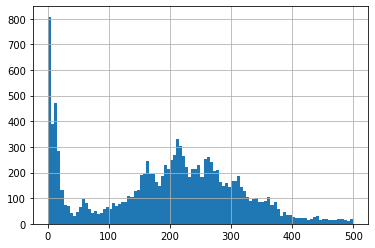

In [11]:
# what is the distribution of title+abstract lengths like?
pd.Series([len(x.split()) for x in tiabss if len(x.split())<500]).hist(bins = 100)

In [12]:
# what is 99th percentile? and 1st percentile
# perhaps drop everything outside of these ranges so that we don't have too many outliers?
pd.Series([len(x.split()) for x in tiabss]).quantile(.04),pd.Series([len(x.split()) for x in tiabss]).quantile(.99)

(1.0, 966.9899999999998)

In [13]:
len([x for x in tiabss if len(x.split())>50 and len(x.split())<500])

10222

No data on publication venue, DOI etc 
- can't use this to find SAGE articles.
- might be able to make a classifier work with it though, but you need another dataset for that.

In [14]:
%%time
# There don't seem to be proper IDs in the data (DOIs/PMIDs etc)
# let's get those from S2's API
# see docs: https://api.semanticscholar.org/
import requests
import time

retry_failures = False

api_data = []
failures = []
api_dict = dict()
filepath = 'data/s2_api_data.json'
failpath = 'data/s2_api_data_failures.json'

# read api data from file from past iterations
if os.path.exists(filepath) and os.path.exists(failpath):
    with open(filepath, 'r') as f:
        api_data = json.load(f)
        api_dict = {x['paperId']: x for x in api_data }
    with open(failpath, 'r') as f:
        failures = json.load(f)


if retry_failures == True or len(api_data)==0:        
    failures = set(failures)
    base_url = 'https://api.semanticscholar.org/v1/paper/'
    paper_ids = [x['paper_id'] for x in data]
    i=0
    for paper_id in [x for x in paper_ids if x not in api_dict]:
        url = base_url+paper_id
        resp = requests.get(url)
        if resp.elapsed.total_seconds()>2:
            time.sleep(2)
        if resp.status_code==200:
            js = resp.json()
            api_data.append(js)
        else:
            if paper_id not in failures:
                failures.add(paper_id)
            
with open(filepath,'w') as f:
    json.dump(api_data,f)
with open(failpath,'w') as f:
    json.dump(list(failures),f)
    
len(api_data), len(failures)

Wall time: 1min 36s


(12640, 1581)

## Exploration
- Would be good to do some clustering on the text data to get a better look at it.
- also look at publication dates.  What rate is content coming out at now?
- which ones are SAGE papers - we should drop the paywall on them.

In [15]:
data[0]

{'paper_id': 'f056da9c64fbf00a4645ae326e8a4339d015d155',
 'metadata': {'title': 'SIANN: Strain Identification by Alignment to Near Neighbors',
  'authors': [{'first': 'Samuel',
    'middle': ['S'],
    'last': 'Minot',
    'suffix': '',
    'affiliation': {},
    'email': ''},
   {'first': 'Stephen',
    'middle': ['D'],
    'last': 'Turner',
    'suffix': '',
    'affiliation': {},
    'email': ''},
   {'first': 'Krista',
    'middle': ['L'],
    'last': 'Ternus',
    'suffix': '',
    'affiliation': {},
    'email': ''},
   {'first': 'Dana',
    'middle': ['R'],
    'last': 'Kadavy',
    'suffix': '',
    'affiliation': {},
    'email': ''}]},
 'abstract': [{'text': 'Next-generation sequencing is increasingly being used to study samples composed of mixtures of organisms, such as in clinical applications where the presence of a pathogen at very low abundance may be highly important. We present an analytical method (SIANN: Strain Identification by Alignment to Near Neighbors) specifica

In [16]:
api_data[0]

{'abstract': 'To study the genetic diversity of enterovirus G (EV-G) among Japanese pigs, metagenomics sequencing was performed on fecal samples from pigs with or without diarrhea, collected between 2014 and 2016. Fifty-nine EV-G sequences, which were >5,000 nucleotides long, were obtained. By complete VP1 sequence analysis, Japanese EV-G isolates were classified into G1 (17 strains), G2 (four strains), G3 (22 strains), G4 (two strains), G6 (two strains), G9 (six strains), G10 (five strains), and a new genotype (one strain). Remarkably, 16 G1 and one G2 strain identified in diarrheic (23.5%; four strains) or normal (76.5%; 13 strains) fecal samples possessed a papain-like cysteine protease (PL-CP) sequence, which was recently found in the USA and Belgium in the EV-G genome, at the 2C-3A junction site. This paper presents the first report of the high prevalence of viruses carrying PL-CP in the EV-G population. Furthermore, possible inter- and intragenotype recombination events were foun

In [17]:
api_data[0].keys()

dict_keys(['abstract', 'arxivId', 'authors', 'citationVelocity', 'citations', 'corpusId', 'doi', 'fieldsOfStudy', 'influentialCitationCount', 'is_open_access', 'is_publisher_licensed', 'paperId', 'references', 'title', 'topics', 'url', 'venue', 'year'])

In [18]:

len(api_dict)

11390

In [19]:
# build a dataframe
columns = ['pid','doi','title','abstract',
           'authors', 'venue','year']
rows = []
for item in data:
    # define a row
    row = {col_name : '' for col_name in columns} #pid,doi,pmid,title,abstract,authors,pub_date,venue,year = '','','','','','','','',''
    row['pid'] = item['paper_id']
    if 'paper_id' in item:
        pid = item['paper_id']
    
        if pid in api_dict:
            api_item = api_dict[pid]
            for key in columns:
                if key in api_item and key!='authors':
                    row[key] = str(api_item[key])
        else:
            
            row['title'] = item['metadata']['title']
            
            abstract = item['abstract']
            abs_text = ''
            if type(abstract) == list and len(abstract)>0:
                for part in abstract:
                    if 'text' in part and len(abs_text)==0:
                        abs_text = part['text']
                    else:
                        abs_text = abs_text+'. '+part['text']
                    if len(abs_text.split())>300:
                        break
                        
            elif 'body_text' in item:
                for text_unit in item['body_text']:
                    if 'text' in text_unit:
                        if len(abs_text)==0:
                            abs_text = text_unit['text']
                        else:
                            abs_text = abs_text +'. ' + text_unit['text']
                    if len(abs_text.split())>300:
                        break
                
            row['abstract'] = abs_text
                
        if 'authors' in item['metadata']:
            row['authors'] = '; '.join([x['last']+', '+x['first'] for x in item['metadata']['authors']])
        rows.append(row)
        


In [20]:
df = pd.DataFrame(rows, columns = columns)
df.shape

(13202, 7)

In [21]:
df.sample(3)

,pid,doi,title,abstract,authors,venue,year
2704,2a7c951e191425fd9fa5ac108f07a1f02eb75872,10.1186/2047-9158-1-9,The changing phenotype of microglia from homeo...,It has been nearly a century since the early d...,"Luo, Xiao-Guang; Chen, Sheng-Di",Translational Neurodegeneration,2012
10259,fc7c462f4b3c1a7e4ab9cf9d7be29353a8595a8c,10.1128/mBio.00002-13,Human Coronavirus EMC Is Not the Same as Sever...,"A newly identified betacoronavirus, human coro...","Perlman, Stanley; Zhao, Jincun",mBio,2013
748,9fb5ca87ca47d35d87161158ae37fc0ca642c51e,,A Mac2-positive progenitor-like microglial pop...,10,"Zhan, Lihong; Sohn, Peter; Zhou, Yungui; Li, Y...",,


At the time of writing, some items appear to be missing from the API.  Possibly this is temporary and we will see the items showing up soon.

Checks for data quality & consistency.

In [22]:
# how much missing data is there
for column in columns:
    print(column,':', df[df[column]==''].shape[0], '/',df.shape[0])

pid : 0 / 13202
doi : 5921 / 13202
title : 568 / 13202
abstract : 0 / 13202
authors : 861 / 13202
venue : 6012 / 13202
year : 5921 / 13202


In [23]:
df[df['title']==''].sample(3)

,pid,doi,title,abstract,authors,venue,year
11249,8cb5954efbc7ab4a0d43db196b9b58b3838945b0,,,Viroporins are small virus-encoded proteins th...,,,
13025,4fc3b508543068a9d54f11f0ecf52580df768307,,,The Centers for Disease Control and Prevention...,"Rao, Carol; Goryoka, Grace; Henao, Olga; Clark...",,
12866,1447cbaffd1c03718da0534b7bfa97435cd3c78d,,,"Animals at Chulalongkorn University (Bangkok, ...",,,


In [24]:
tiabs = []
for i,row in df.iterrows():
    if len(row['title'])==0:
        tiabs.append(row['abstract'])
    else:
        tiabs.append(row['title'] + '. ' + row['abstract'])
df['tiabs'] = tiabs

In [25]:
df.to_csv('data/s2_data.csv', encoding = 'utf-8-sig', index=False)

# Add CrossRef data
There are a lot of DOIs in the data. Unfortunately, many of them are not CrossRef DOIs (either DOIs from other registrars or errors). The functions I have for retrieving DOIs are only meant for getting a list of CrossRef DOIs, so they are a little slow here. 

In [26]:
# get crossref data incase you need it
import urllib
import requests
import time
from datetime import datetime as dt


def chunks(l, n):
    '''
    converts a list into a list of lists each with max length == n
    '''
    # For item i in a range that is a length of l,
    for i in range(0, len(l), n):
        # Create an index range for l of n items:
        yield l[i:i+n]

def get_one_crossref(doi, headers, email = 'adamday1284@gmail.com'):
    url = r'http://api.crossref.org/works/{}'.format(urllib.parse.quote(doi))
    r = requests.get(url, headers = headers)
    try:
        if r.json()['status']!='failed':
            return [r.json()['message']] # output should be a list for consistency
        else:
            print('failure for doi:',doi)
            print('(skipping)')
            raise # or return None?
    except:
        print('Error in response.  Not interpretable as json?')
        print('Searched for:', doi)
        print('Trying unescaped doi')
        url = r'http://api.crossref.org/works/{}'.format(doi)
        r = requests.get(url, headers = headers)
        try:
            js = r.json()
            if r.json()['status']!='failed':
                return [r.json()['message']] # output should be a list for consistency
            else:
                print('failure for doi:',doi)
                print('(skipping)')
                return None
            print('taking a break - sleep for 10s')
            time.sleep(10)
            return None
        except Exception as e:
            print('Error: ',e)
            return None

def get_many_crossref(dois, email = ''):
    '''
    Pulls a list of CR DOIs all at once.
    Yields output json for each batch for analysis/caching.
    -- Note that batch_size==100 seems to be a limit --
    packages: urllib, requests, time
    functions: chunks
    '''

    headers = {
    'User-Agent': 'Data analysis',
    'mailto': email
    }

    # make generator of lists
    batch_size = 100
    doi_batches = chunks(dois,batch_size)
    i = 0
    for doi_batch in doi_batches:

        # make query string
        dois_s = 'doi:' + ',doi:'.join(doi_batch)
        # Crossref documentation recommends %-encoding dois
        dois_s = urllib.parse.quote(dois_s)
        # build query url
        url = r'http://api.crossref.org/works/?filter={}&rows={}'.format(dois_s, batch_size)
        # make request
        r = requests.get(url, headers = headers)

        # check response time.
        # Documentation recommends backing off if response time is too long.
        response_time = r.elapsed.total_seconds()
        print(response_time, 'seconds for last request')

        # responses are generally <1s.
        # simple rule for sleeping if responses are slow
        if response_time > 2.0:
            print('CrossRef slow to respond. Sleep for a few seconds.')
            time.sleep(int(response_time))
            print('Finished sleeping')

        data = r.json()
        i+=1

        if data['status'] != 'failed':
            records = data['message']['items']
            n_results = len(records)

            print(dt.now())
            print(i, 'requests done')

            print(batch_size, 'items requested')
            print(n_results,'items returned')
            print('---------------------------------')

            out = data['message']['items']

            if n_results < batch_size:
                dois_returned = [record['DOI'] for record in records]
                failed_dois = [doi for doi in doi_batch
                                if doi not in dois_returned]
                if len(failed_dois)>0:
                    print('Retrieving remaining DOIs one at a time')
                    for doi in failed_dois:
                        doi_result = get_one_crossref(doi=doi, headers=headers)
                        if doi_result == None:
                            pass
                        else:
                            if type(doi_result)==dict and 'message' in doi_result:
                                out.append(doi_result['message'])
                            else:
                                out=None


            yield out
        else:
            # if there's a failure, it's likely because of a typo in a doi
            # this should retrieve all other dois in the batch
            print('Failure! - invalid doi somewhere in batch?')
            print('iterating over each item in batch:')
            for doi in doi_batch:
                out = get_one_crossref(doi=doi, headers = headers)
                if out != None:
                    yield out
                else:
                    pass



# get all crossref dates
from dateutil import parser
import datetime
from dateutil.tz import tzutc

"""
The next fn is a result of CrossRef not always having an accurate publication
date.  So, we take a best-guess that the earliest date associated with the
record is probably the publication date, or the closest thing to it.
"""
from dateutil import parser
def cr_earliest_date(works_record):
    '''
    Takes a CrossRef works record and returns the earliest date associated with it.
    packages: dateutil.parser
    '''
    date_types = ['created', 'deposited', 'indexed', 'issued',
                  'published-online', 'published-print']
    dates = []
    for date_type in date_types:
        # date_types are often missing in CrossRef works records, so we're checking
        if date_type in works_record:
            date_dict = works_record[date_type]
            for thing in date_dict:
                try:
                    dates.append(parser.parse(date_dict[thing]))
                except:
                    # in case the parser fails
                    pass
        else:
            pass
    earliest = min(dates)
    return earliest

In [28]:
%%time

cr_data_path = os.path.abspath('data/cr_data.json')
cr_data = []
if os.path.exists(cr_data_path):
    with open(cr_data_path, 'r') as f:
        cr_data = json.load(f)
cr_dict = {x['DOI']:x for x in cr_data}  
print('Already got data for ', len(cr_dict), ' crossref dois.')
dois = list(set([x for x in df['doi'].tolist() if x not in {'',None,'None'} and x not in cr_dict]))
for x in get_many_crossref(dois, email = os.environ['myemail']):
    if type(x)==list:
        cr_data.extend(x)
        
with open(cr_data_path,'w') as f:
    json.dump(cr_data,f)
cr_dict = {x['DOI']:x for x in cr_data}  
len(cr_data), len(cr_dict)

3.344814 seconds for last request
CrossRef slow to respond. Sleep for a few seconds.
Finished sleeping
2020-03-18 11:24:51.892462
1 requests done
100 items requested
100 items returned
---------------------------------
4.917929 seconds for last request
CrossRef slow to respond. Sleep for a few seconds.
Finished sleeping
2020-03-18 11:25:01.649535
2 requests done
100 items requested
97 items returned
---------------------------------
Retrieving remaining DOIs one at a time
Error in response.  Not interpretable as json?
Searched for: 10.21010/ajid.v12i1.5
Trying unescaped doi
Error:  Expecting value: line 1 column 1 (char 0)
Error in response.  Not interpretable as json?
Searched for: 10.3390/ijerph121013289
Trying unescaped doi
Error:  Expecting value: line 1 column 1 (char 0)
Error in response.  Not interpretable as json?
Searched for: 10.3390/v7102891
Trying unescaped doi
Error:  Expecting value: line 1 column 1 (char 0)
2.551685 seconds for last request
CrossRef slow to respond. Slee

5600

In [32]:
cr_dict = {x['DOI']:x for x in cr_data}  

In [48]:
cr_journals = []
cr_journals_short = []
cr_issns = []
publishers = []
pubdates = []
for doi in df['doi'].tolist():
    cr_journal, cr_journal_short,cr_issn, publisher, pubdate = '','','','',''
    
    if doi in cr_dict:
        item = cr_dict[doi]
    
        if 'ISSN' in item:
            cr_issn = '; '.join(item['ISSN'])
    
        pubdate = str(cr_earliest_date(item))[:10]
        
        if 'publisher' in item:
            publisher = item['publisher']
            
        if 'container-title' in item:
            cr_journal = item['container-title'][0]
            
        if 'short-container-title' in item:
            cr_journal_short = item['short-container-title'][0]
        
    else:
        pass
    
    cr_journals.append(cr_journal)
    cr_journals_short.append(cr_journal_short)
    cr_issns.append(cr_issn)
    publishers.append(publisher)
    pubdates.append(pubdate)

In [49]:
df['journal'] = cr_journals
df['journal-short'] = cr_journals_short
df['pubdate'] = pubdates
df['issns'] = cr_issns
df['publisher'] = publishers

df.shape


(13202, 13)

In [50]:
df.sample(10)

,pid,doi,title,abstract,authors,venue,year,tiabs,journal,journal-short,pubdate,issns,publisher
6495,07899a6af647ba443bf04599aa35d111d0d08cb3,10.3390/brainsci7070078,Multiple Sclerosis: Immunopathology and Treatm...,The treatment of multiple sclerosis (MS) has c...,"Dargahi, Narges; Katsara, Maria; Tselios, Theo...",Brain sciences,2017,Multiple Sclerosis: Immunopathology and Treatm...,,,,,
11297,4ee0f8eb93dda0ff3512556fbb784c3859cc156f,,Jet set pets: examining the zoonosis risk in a...,Ownership of companion animals or pets is popu...,"Fooks, Anthony; Johnson, Nicholas",,,Jet set pets: examining the zoonosis risk in a...,,,,,
10458,963c0263d2acd998d323aabd13c7c103bb44f6d3,10.1038/ncomms5323,Reconstructing propagation networks with natur...,Our ability to uncover complex network structu...,"Shen, Zhesi; Wang, Wen-Xu; Fan, Ying; Di, Zeng...",Nature communications,2014,Reconstructing propagation networks with natur...,Nature Communications,Nat Commun,2014-07-11,2041-1723,Springer Science and Business Media LLC
2801,5e11e3105842cf7cedf10e26bff170a52c23cf00,10.1371/journal.ppat.1003124,IFITM Proteins Restrict Viral Membrane Hemifusion,The interferon-inducible transmembrane (IFITM)...,"Li, K; Markosyan, R; Zheng, Y-M; Golfetto, O; ...",PLoS pathogens,2013,IFITM Proteins Restrict Viral Membrane Hemifus...,PLoS Pathogens,PLoS Pathog,2013-01-24,1553-7374,Public Library of Science (PLoS)
290,cc41c51293ed24a57ddf467e462ec9399463ee33,,No more business as usual: agile and effective...,"5,6 , usegalaxy.be 7,8 and hyphy.org 9 develop...","Org, Usegalaxy; Baker, Dannon; Van Den Beek, M...",,,No more business as usual: agile and effective...,,,,,
9245,89fc23ed55ad474b4b4056c0a3dadd315573f57e,,A Novel Bacterium-Like Particle Vaccine Displa...,Middle East respiratory syndrome coronavirus (...,"Li, Entao; Chi, Hang; Huang, Pei; Yan, Feihu; ...",,,A Novel Bacterium-Like Particle Vaccine Displa...,,,,,
12218,d66d18ad33170f29a2279d8cc4ca3e31bdee67f0,10.3201/eid1201.051024,H5N1 Outbreaks and Enzootic Influenza,Ongoing outbreaks of H5N1 avian influenza in m...,"Webster, Robert; Peiris, Malik; Chen, Honglin;...",Emerging infectious diseases,2006,H5N1 Outbreaks and Enzootic Influenza. Ongoing...,Emerging Infectious Diseases,Emerg. Infect. Dis.,2012-02-03,1080-6040; 1080-6059,Centers for Disease Control and Prevention (CDC)
12376,76afb423879efd78bcd26ac2be9086727030f990,,Four cases of severe acute respiratory syndrom...,"in the city of Guangzhou, Guangdong Province, ...",,,,Four cases of severe acute respiratory syndrom...,,,,,
10181,b7d7db5b12584c5fab0c2244a27d0653d8a59f7d,10.3389/fmicb.2012.00068,Mouse Hepatitis Virus Receptor as a Determinan...,"In this review, we report that the receptor of...","Taguchi, Fumihiro; Hirai-Yuki, Asuka",Front. Microbio.,2012,Mouse Hepatitis Virus Receptor as a Determinan...,Frontiers in Microbiology,Front. Microbio.,2012-02-24,1664-302X,Frontiers Media SA
1194,4cd8e92fcab8da2c840ff39f14ca35bf5ba6e444,10.1186/1471-2288-8-20,Graphical presentation of diagnostic information,BackgroundGraphical displays of results allow ...,"Whiting, Penny; Ac, Jonathan; , Sterne; Westwo...",BMC medical research methodology,2008,Graphical presentation of diagnostic informati...,BMC Medical Research Methodology,BMC Med Res Methodol,2008-04-11,1471-2288,Springer Science and Business Media LLC


In [52]:
# df[[('SAGE' in x) for x in df['publisher']]].to_excel('output/SAGE_in_s2.xlsx')

In [1]:
df['publisher'].value_counts()

NameError: name 'df' is not defined